In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [3]:
data_path = '/home/sean/mea data/027/027_spk_freq_table_2_bin60.csv'
data_table = pd.read_csv(data_path)
#time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

In [4]:
# define mapping of wells to power and width, based on time
start_times = pd.Series(["2017-07-28 18:08:00", "2017-07-29 00:08:00", "2017-07-29 06:08:00", "2017-07-29 12:08:00", 
              "2017-07-29 18:08:00", "2017-07-30 00:08:00", "2017-07-30 06:08:00", "2017-07-31 12:08:00"])
start_times = start_times.map(mc.remapped_str_to_datetime)


def well_power(time):
    full_diff = np.abs(start_times-time).min()
    print(full_diff)
    secDiff = int(full_diff.total_seconds())
    time_diff = secDiff / 60

    if time_diff <= 5 or (time_diff > 10 and time_diff <= 15) or (time_diff > 30 and time_diff <= 35):
        return 100.0
    elif (time_diff > 5 and time_diff <= 10) or (time_diff > 15 and time_diff <= 20) or (time_diff > 35 and time_diff <= 40):
        return 50.0
    elif (time_diff > 20 and time_diff <= 25) or (time_diff > 40 and time_diff <= 45):
        return 25.0
    elif (time_diff > 25 and time_diff <= 30) or (time_diff > 45):
        return 12.0
    else:
        return 0
    
def well_width(time):
    full_diff = np.abs(start_times-time).min()
    secDiff = int(full_diff.total_seconds())
    time_diff = secDiff / 60

    if time_diff <= 10:
        return 0.2
    elif time_diff > 10 and time_diff <= 30:
        return 0.5
    elif time_diff > 30:
        return 1.0

In [5]:
def is_all(unit_name):
    return True

cond_filt = {
    'All': is_all
}

In [6]:
cat_table = plotting.construct_categorized_dataframe(data_table, cond_filt)
cat_table = cat_table.query('unit_name < "F1111"') # delete F row, because no data
cat_table['spike_freq'] = cat_table['spike_freq']/60 # convert from spikes/1 minute to spikes/sec

In [7]:
cat_table['spike_freq'] = cat_table['spike_freq']/2 # convert from spikes/sec to spikes/pulse

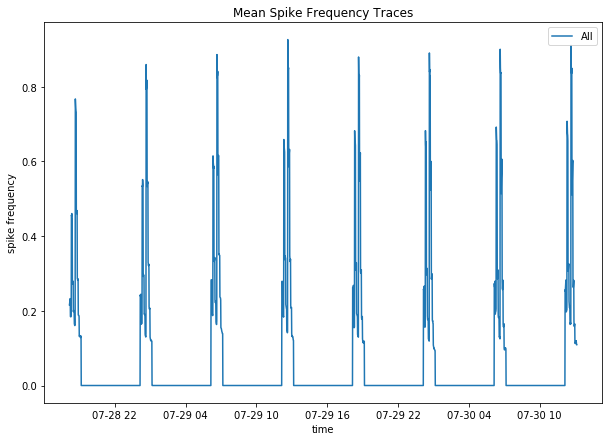

In [10]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table)

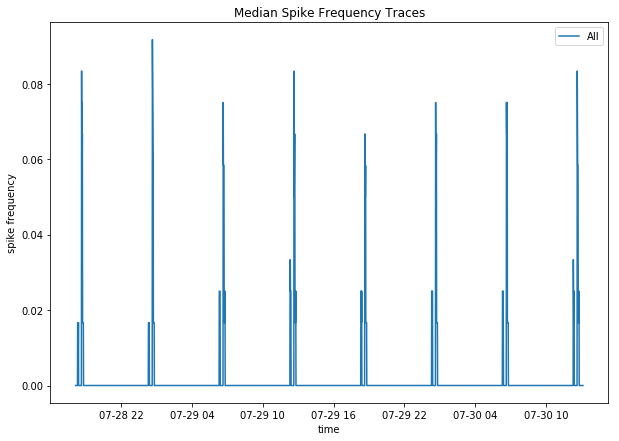

In [92]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table, quartiles = False)

In [10]:
rec_start_times = pd.date_range('2017-07-28 18:09:00', periods = 8, freq = '6H') #skip 1st minute
rec_stop_times = pd.date_range('2017-07-28 19:08:00', periods = 8, freq = '6H')

all_recs_table = pd.DataFrame()

for start, stop in zip(rec_start_times, rec_stop_times):
    rec_table = cat_table.query('time > @start and time < @stop')
    rec_table.loc[:,'time'] = rec_table.loc[:,'time'] - start
    all_recs_table = all_recs_table.append(rec_table)

rec_mean = all_recs_table.groupby(('condition','time'))['spike_freq'].mean()
rec_mean = rec_mean.reset_index()

/home/sean/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


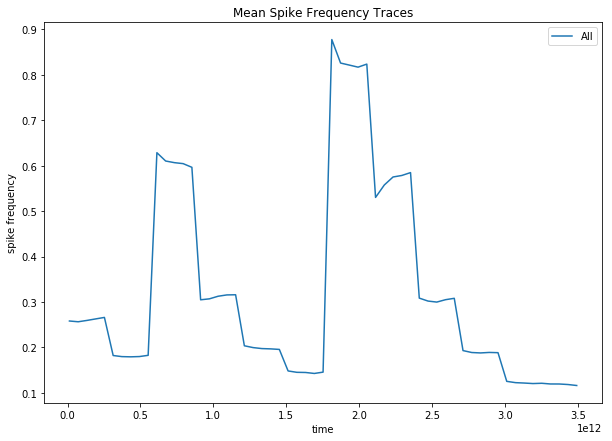

In [14]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(rec_mean)

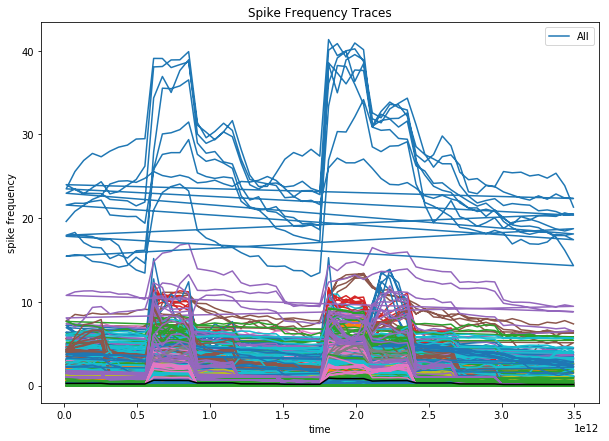

In [15]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(all_recs_table)

In [8]:
def light_response_filter(all_recs_table):
    high_resp = all_recs_table.query('time >= "00:30:00" and time < "00:35:00"')
    high_means = high_resp.groupby('unit_name')['spike_freq'].mean()
    high_means = high_means.reset_index()
    low_resp = all_recs_table.query('time >= "00:50:00" and time < "00:60:00"')
    low_means = low_resp.groupby('unit_name')['spike_freq'].mean()
    low_means = low_means.reset_index()
    filt = high_means['spike_freq'] > low_means['spike_freq']
    return high_means.loc[filt,'unit_name']

In [11]:
filtered_units = light_response_filter(all_recs_table)
filtered_table = all_recs_table.loc[all_recs_table['unit_name'].isin(filtered_units)]

In [15]:
len(filtered_table['unit_name'].unique())

435

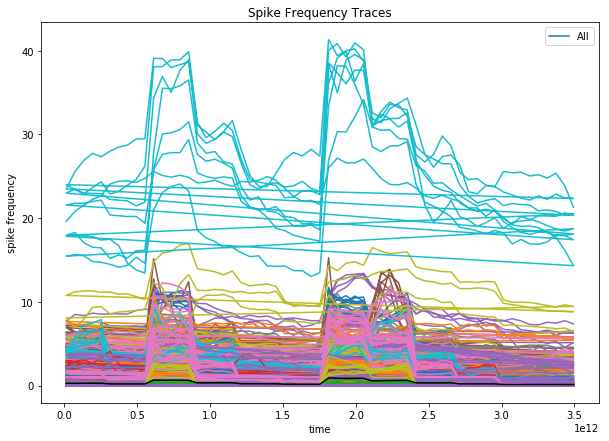

In [75]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(filtered_table)
#plt.yscale('log')

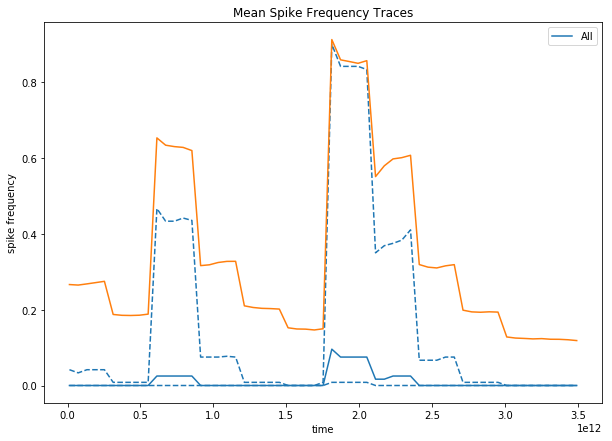

In [86]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(filtered_table)
plotting.plot_mean_frequency_traces(filtered_table)

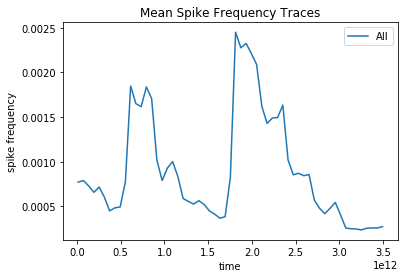

In [93]:
plotting.plot_mean_frequency_traces(filtered_table.query('spike_freq < 0.01'))

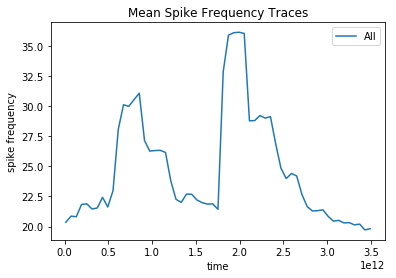

In [97]:
plotting.plot_mean_frequency_traces(filtered_table.query('spike_freq > 15'))